### Set-up: The jupyter notebook expects the following:
    1. The test data is cleaned, uploaded into s3 for quick evaluation:
        s3 URI: s3://sagemaker-sigparser-caylent-mlops/data/email-type/input/processed/
    2. To test the e-mail type, the data should have the columns - Email Address, Email Address Name, Email Address Display Name and Email Type
    3. The prompt is created in the prompts/email-type.py
    4. The endpoint is deployed in sagemaker for inference.
    5. Make sure to initialize all the pre-requisites in the section: Pre-requisites


### Output:
    1. Evaluation results, along with the prediction results are saved in the s3, based on the model used:
        s3 URI: s3://sagemaker-sigparser-caylent-mlops/data/email-type/output/Mistral-7B/
    2. Confusion matrix with all the relevant data is generated within the jupyter notebook.

#### model: Mistral_7B
#### endpoint_name = 'hf-llm-mistral-7b-2024-03-26-20-15-13-644'

In [2]:
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import pandas as pd
import sys
import datetime
sys.path.append('..')
from utils.metrics import Evaluate
from utils.utils import Mistral_7B_V1
from prompts.email_type import prompt_email_type
from utils.s3_helper import read_s3_csv_to_dataframe, upload_dataframe_to_s3, upload_data_to_s3

####  Pre-requisites: Initialize

In [3]:
# endpoint annd model data
endpoint_name = 'hf-llm-mistral-7b-2024-03-26-20-15-13-644'
model = "Mistral-7B"
model_version = "2.3.0"
model_id = "huggingface-llm-mistral-7b"

# s3bucket used
bucket_name = 'sagemaker-sigparser-caylent-mlops'

# input data
# s3_file_name = 'data/email-type/input/processed/cleaned_test_data.csv'
s3_file_key = 'data/email-type/input/processed/25-03-2024_test.csv'

###  Load the Test  Dataset

In [4]:
cleaned_holdout_df = read_s3_csv_to_dataframe(bucket_name, s3_file_key)

# Use the below code to read the cleaned data locally
# cleaned_holdout_df = pd.read_csv('../data/test-data/data-March-11/cleaned_test_data.csv')
cleaned_holdout_df.shape

(2000, 4)

#### Configure test records

In [5]:
# set the record_count number accordingly for quick test purpose(number should be between)
# by default we can use the length of the dataframe itself.
# record_count = len(cleaned_holdout_df)
record_count = 5
temp_test_data = ""
temp_test_data = cleaned_holdout_df.head(record_count).copy()
temp_test_data.iloc[0]

Email Address                 !india_cbre-marketing@cbre.com
Email Address Name                     !india_cbre-marketing
Email Address Display Name              CBRE India Marketing
Email Type                                        Non-Person
Name: 0, dtype: object

In [6]:
temp_test_data.shape

(5, 4)

In [7]:
temp_test_data

,Email Address,Email Address Name,Email Address Display Name,Email Type
0,!india_cbre-marketing@cbre.com,!india_cbre-marketing,CBRE India Marketing,Non-Person
1,000956928@dxb.icbc,956928,柏佳宁Bai_jianing,Non-Person
2,01b8db1c882@syins.co.nz,01b8db1c882,"☎ ""Ring Central®""=+== (vn.notification_service...",Non-Person
3,03501ybr@alight.com,03501ybr,MyAccount Resource Center,Non-Person
4,05inmuebles@gmail.com,05inmuebles,HirCasa,Non-Person


#### Get the prompt and print prompt version to confirm.

In [8]:
system_prompt = prompt_email_type["system_prompt"]
instruction = prompt_email_type["instruction"]
prompt_version = prompt_email_type["prompt_version"]
prompt_type = prompt_email_type["prompt_type"]
print(" prompt_version:", prompt_version)

 prompt_version: version-6


#### Prepare the user ask with all the relevant data for the question

In [9]:
def get_context(email_address, email_address_name, email_display_name):
    email_address = email_address.strip()
    email_address_name = email_address_name.strip()
    email_display_name = email_display_name.strip()
    context_input_str = f"""Input:"""
    context_data = f"""{{"email_address":"{email_address}", "email_address_name":"{email_address_name}", "email_display_name":"{email_display_name}"}}"""
    context = context_input_str.strip() + context_data.strip()
    return context


contexts = temp_test_data.apply(lambda x: get_context(x['Email Address'], x['Email Address Name'], x['Email Address Display Name']), axis=1)

In [10]:
contexts[0]

'Input:{"email_address":"!india_cbre-marketing@cbre.com", "email_address_name":"!india_cbre-marketing", "email_display_name":"CBRE India Marketing"}'

### Prepare the prompts for all the test records

In [11]:
prompt_df = pd.DataFrame({'system_prompt':system_prompt,
                         'instruction':instruction,
                          'context': contexts,
                         'prompt_type':prompt_type
                        })
prompt_df.head()

,system_prompt,instruction,context,prompt_type
0,You are a helpful and detail-oriented assistan...,Please classify this email address for me. All...,"Input:{""email_address"":""!india_cbre-marketing@...",email-type
1,You are a helpful and detail-oriented assistan...,Please classify this email address for me. All...,"Input:{""email_address"":""000956928@dxb.icbc"", ""...",email-type
2,You are a helpful and detail-oriented assistan...,Please classify this email address for me. All...,"Input:{""email_address"":""01b8db1c882@syins.co.n...",email-type
3,You are a helpful and detail-oriented assistan...,Please classify this email address for me. All...,"Input:{""email_address"":""03501ybr@alight.com"", ...",email-type
4,You are a helpful and detail-oriented assistan...,Please classify this email address for me. All...,"Input:{""email_address"":""05inmuebles@gmail.com""...",email-type


### Init Mistral_7B endpoint

In [12]:
# Mistral_7B
mistral = Mistral_7B_V1(endpoint_name=endpoint_name)

#### Use pool of worker threads for for concurrent execution of tasks

In [13]:
%%time
results = ""
with ThreadPoolExecutor() as executor:
    results = list(tqdm(executor.map(mistral.get_results, prompt_df.iterrows()), total=len(prompt_df)))

100%|██████████| 5/5 [00:01<00:00,  4.57it/s]

Function 'query_mistral_endpoint' took 1.10994 seconds to execute.
Function 'check_email_type' took 0.00020 seconds to execute.
Function 'extract_results' took 0.00021 seconds to execute.
Function 'get_results' took 1.11048 seconds to execute.
Function 'query_mistral_endpoint' took 1.11869 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00004 seconds to execute.
Function 'get_results' took 1.11888 seconds to execute.
Function 'query_mistral_endpoint' took 1.11505 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 1.11516 seconds to execute.
Function 'query_mistral_endpoint' took 1.10681 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 1.10703 seconds to execute.
Function 'query_mistral_

#### Results post processing

In [14]:
p_email_type_values = [d['p_email_type'] for d in results]

temp_test_data['pred_email_type'] = p_email_type_values

temp_test_data

,Email Address,Email Address Name,Email Address Display Name,Email Type,pred_email_type
0,!india_cbre-marketing@cbre.com,!india_cbre-marketing,CBRE India Marketing,Non-Person,Non-Person
1,000956928@dxb.icbc,956928,柏佳宁Bai_jianing,Non-Person,Non-Person
2,01b8db1c882@syins.co.nz,01b8db1c882,"☎ ""Ring Central®""=+== (vn.notification_service...",Non-Person,Non-Person
3,03501ybr@alight.com,03501ybr,MyAccount Resource Center,Non-Person,Non-Person
4,05inmuebles@gmail.com,05inmuebles,HirCasa,Non-Person,Non-Person


In [15]:
for col in temp_test_data.columns:
    print(col)

Email Address
Email Address Name
Email Address Display Name
Email Type
pred_email_type


### Calculate Metrics

#### JACCARD INDEX

In [16]:
jaccard_email_type = Evaluate().compute_jaccard_score(temp_test_data['pred_email_type'], temp_test_data['Email Type'].str.strip())

temp_test_data['jaccard_email_type'] = jaccard_email_type

temp_test_data.head() 

,Email Address,Email Address Name,Email Address Display Name,Email Type,pred_email_type,jaccard_email_type
0,!india_cbre-marketing@cbre.com,!india_cbre-marketing,CBRE India Marketing,Non-Person,Non-Person,1.0
1,000956928@dxb.icbc,956928,柏佳宁Bai_jianing,Non-Person,Non-Person,1.0
2,01b8db1c882@syins.co.nz,01b8db1c882,"☎ ""Ring Central®""=+== (vn.notification_service...",Non-Person,Non-Person,1.0
3,03501ybr@alight.com,03501ybr,MyAccount Resource Center,Non-Person,Non-Person,1.0
4,05inmuebles@gmail.com,05inmuebles,HirCasa,Non-Person,Non-Person,1.0


In [17]:
temp_test_data['jaccard_email_type'].value_counts(dropna=False, normalize=True).head()

jaccard_email_type
1.0    1.0
Name: proportion, dtype: float64

#### Calculate Accuracy, precision, recall, f1-score and confusion matrix

Accuracy: 1.000
Accuracy for label 1: 1.000


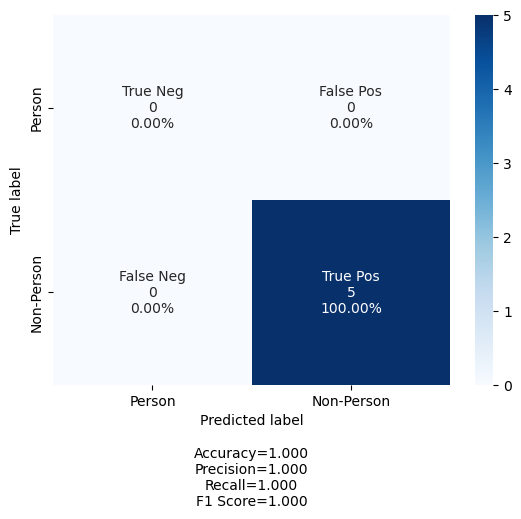

In [18]:
y_true = temp_test_data['Email Type']
y_pred = temp_test_data['pred_email_type']
evaluation_results = Evaluate().compute_evaluation_metrics(y_true, y_pred)

#### Save the output file in s3

In [19]:
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
object_name = f"data/email-type/output/{model}/email_type_prediction_results_{timestamp}"
# Create the file name as per the task: name-parse, email-signature
file_name = f"email_type_prediction_results_{timestamp}.csv"
upload_dataframe_to_s3(bucket_name, object_name, file_name, temp_test_data)

# Save the file locally to quickly check the data
# temp_test_data.to_csv(file_name, index=True)

#### Save the results summary in s3

In [20]:
input_data_uri = r's3://{0}/{1}'.format(bucket_name, s3_file_key)
output_data_uri = r's3://{0}/{1}/{2}'.format(bucket_name, object_name, file_name)

results_summary = {
    "input_data": input_data_uri,
    "model_id": model_id,
    "model_version": model_version,
    "prompt_version": prompt_version,
    "system_prompt":system_prompt,
    "instruction_sample": instruction,
    "output_data": output_data_uri,
    "evaluation_results": evaluation_results
}
upload_data_to_s3(results_summary, bucket_name, object_name)

Data upload successfull s3_uri:  s3://sagemaker-sigparser-caylent-mlops/data/email-type/output/Mistral-7B/email_type_prediction_results_2024-03-27_22-23-42/results_summary.json


True

In [21]:
evaluation_results

{'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}